# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.9/500.9 KB 7.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 KB 10.5 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 KB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 KB 28.4 MB/s eta 0:00:00
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 10.4 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [9]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [10]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [11]:
client = MongoClient(mongod_connect)
db = client.lab9 # use or create a database named demo
tweet_collection = db.twitter_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [12]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [13]:
count = 100 #number of returned tweets, default and max is 100
geocode = "38.4392897,-78.9412224,50mi"  # defin the location, in Harrisonburg, VA
q = "election"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [14]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Mon Nov 14 21:08:40 +0000 2022'
'Mon Nov 14 20:34:09 +0000 2022'
'Mon Nov 14 20:27:13 +0000 2022'
'Mon Nov 14 20:12:51 +0000 2022'
'Mon Nov 14 20:12:44 +0000 2022'
'Mon Nov 14 20:07:18 +0000 2022'
'Mon Nov 14 20:05:24 +0000 2022'
'Mon Nov 14 19:50:48 +0000 2022'
'Mon Nov 14 19:35:02 +0000 2022'
'Mon Nov 14 19:34:23 +0000 2022'
'Mon Nov 14 19:26:56 +0000 2022'
'Mon Nov 14 19:21:33 +0000 2022'
'Mon Nov 14 19:20:52 +0000 2022'
'Mon Nov 14 19:19:16 +0000 2022'
'Mon Nov 14 19:08:28 +0000 2022'
'Mon Nov 14 19:06:58 +0000 2022'
'Mon Nov 14 19:05:34 +0000 2022'
'Mon Nov 14 19:04:15 +0000 2022'
'Mon Nov 14 19:01:25 +0000 2022'
'Mon Nov 14 18:40:27 +0000 2022'
'Mon Nov 14 18:06:47 +0000 2022'
'Mon Nov 14 17:52:27 +0000 2022'
'Mon Nov 14 17:52:06 +0000 2022'
'Mon Nov 14 17:40:52 +0000 2022'
'Mon Nov 14 17:25:43 +0000 2022'
'Mon Nov 14 17:18:30 +0000 2022'
'Mon Nov 14 17:16:49 +0000 2022'
'Mon Nov 14 16:59:50 +0000 2022'
'Mon Nov 14 16:52:14 +0000 2022'
'Mon Nov 14 16:51:31 +0000 2022'
'Mon Nov 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [15]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Mon Nov 14 05:11:14 +0000 2022'
'Mon Nov 14 05:04:59 +0000 2022'
'Mon Nov 14 05:01:10 +0000 2022'
'Mon Nov 14 05:00:02 +0000 2022'
'Mon Nov 14 04:50:46 +0000 2022'
'Mon Nov 14 04:47:31 +0000 2022'
'Mon Nov 14 04:35:36 +0000 2022'
'Mon Nov 14 04:30:31 +0000 2022'
'Mon Nov 14 03:59:04 +0000 2022'
'Mon Nov 14 03:54:01 +0000 2022'
'Mon Nov 14 03:23:32 +0000 2022'
'Mon Nov 14 03:19:51 +0000 2022'
'Mon Nov 14 03:15:57 +0000 2022'
'Mon Nov 14 03:14:36 +0000 2022'
'Mon Nov 14 03:02:35 +0000 2022'
'Mon Nov 14 02:58:55 +0000 2022'
'Mon Nov 14 02:51:03 +0000 2022'
'Mon Nov 14 02:47:05 +0000 2022'
'Mon Nov 14 02:45:38 +0000 2022'
'Mon Nov 14 02:36:47 +0000 2022'
'Mon Nov 14 02:27:31 +0000 2022'
'Mon Nov 14 02:15:53 +0000 2022'
'Mon Nov 14 02:01:09 +0000 2022'
'Mon Nov 14 01:57:08 +0000 2022'
'Mon Nov 14 01:54:31 +0000 2022'
'Mon Nov 14 01:48:57 +0000 2022'
'Mon Nov 14 01:45:38 +0000 2022'
'Mon Nov 14 01:37:03 +0000 2022'
'Mon Nov 14 01:36:18 +0000 2022'
'Mon Nov 14 01:30:38 +0000 2022'
'Mon Nov 1

'Sat Nov 12 18:47:22 +0000 2022'
'Sat Nov 12 18:42:43 +0000 2022'
'Sat Nov 12 18:39:31 +0000 2022'
'Sat Nov 12 18:38:11 +0000 2022'
'Sat Nov 12 18:36:52 +0000 2022'
'Sat Nov 12 18:35:00 +0000 2022'
'Sat Nov 12 18:30:21 +0000 2022'
'Sat Nov 12 18:21:09 +0000 2022'
'Sat Nov 12 18:05:46 +0000 2022'
'Sat Nov 12 18:04:46 +0000 2022'
'Sat Nov 12 17:52:57 +0000 2022'
'Sat Nov 12 17:48:05 +0000 2022'
'Sat Nov 12 17:22:45 +0000 2022'
'Sat Nov 12 17:03:37 +0000 2022'
'Sat Nov 12 16:54:13 +0000 2022'
'Sat Nov 12 16:49:42 +0000 2022'
'Sat Nov 12 16:45:02 +0000 2022'
'Sat Nov 12 15:57:24 +0000 2022'
'Sat Nov 12 15:43:18 +0000 2022'
'Sat Nov 12 15:32:08 +0000 2022'
'Sat Nov 12 15:32:03 +0000 2022'
'Sat Nov 12 14:57:16 +0000 2022'
'Sat Nov 12 14:51:16 +0000 2022'
'Sat Nov 12 14:43:44 +0000 2022'
'Sat Nov 12 14:37:34 +0000 2022'
'Sat Nov 12 14:11:56 +0000 2022'
'Sat Nov 12 14:06:33 +0000 2022'
'Sat Nov 12 14:04:40 +0000 2022'
'Sat Nov 12 14:00:38 +0000 2022'
'Sat Nov 12 13:58:22 +0000 2022'
'Sat Nov 1

'Fri Nov 11 03:31:50 +0000 2022'
'Fri Nov 11 03:26:21 +0000 2022'
'Fri Nov 11 03:25:23 +0000 2022'
'Fri Nov 11 03:24:47 +0000 2022'
'Fri Nov 11 03:21:22 +0000 2022'
'Fri Nov 11 03:07:03 +0000 2022'
'Fri Nov 11 03:02:33 +0000 2022'
'Fri Nov 11 03:00:11 +0000 2022'
'Fri Nov 11 02:55:11 +0000 2022'
'Fri Nov 11 02:53:10 +0000 2022'
'Fri Nov 11 02:48:34 +0000 2022'
'Fri Nov 11 02:46:43 +0000 2022'
'Fri Nov 11 02:35:36 +0000 2022'
'Fri Nov 11 02:21:38 +0000 2022'
'Fri Nov 11 02:17:35 +0000 2022'
'Fri Nov 11 02:16:48 +0000 2022'
'Fri Nov 11 02:11:08 +0000 2022'
'Fri Nov 11 02:08:01 +0000 2022'
'Fri Nov 11 02:04:19 +0000 2022'
'Fri Nov 11 02:04:09 +0000 2022'
'Fri Nov 11 02:03:02 +0000 2022'
'Fri Nov 11 02:00:30 +0000 2022'
'Fri Nov 11 01:58:05 +0000 2022'
'Fri Nov 11 01:51:08 +0000 2022'
'Fri Nov 11 01:38:34 +0000 2022'
'Fri Nov 11 01:32:34 +0000 2022'
'Fri Nov 11 01:30:00 +0000 2022'
'Fri Nov 11 01:28:26 +0000 2022'
'Fri Nov 11 01:27:52 +0000 2022'
'Fri Nov 11 01:26:15 +0000 2022'
'Fri Nov 1

'Thu Nov 10 00:17:31 +0000 2022'
'Thu Nov 10 00:15:33 +0000 2022'
'Thu Nov 10 00:15:28 +0000 2022'
'Thu Nov 10 00:15:03 +0000 2022'
'Thu Nov 10 00:11:27 +0000 2022'
'Thu Nov 10 00:11:21 +0000 2022'
'Thu Nov 10 00:10:24 +0000 2022'
'Thu Nov 10 00:08:27 +0000 2022'
'Thu Nov 10 00:06:32 +0000 2022'
'Thu Nov 10 00:04:23 +0000 2022'
'Thu Nov 10 00:02:15 +0000 2022'
'Thu Nov 10 00:01:22 +0000 2022'
'Wed Nov 09 23:55:28 +0000 2022'
'Wed Nov 09 23:55:02 +0000 2022'
'Wed Nov 09 23:52:02 +0000 2022'
'Wed Nov 09 23:51:32 +0000 2022'
'Wed Nov 09 23:47:27 +0000 2022'
'Wed Nov 09 23:39:39 +0000 2022'
'Wed Nov 09 23:38:04 +0000 2022'
'Wed Nov 09 23:37:31 +0000 2022'
'Wed Nov 09 23:35:39 +0000 2022'
'Wed Nov 09 23:32:01 +0000 2022'
'Wed Nov 09 23:25:09 +0000 2022'
'Wed Nov 09 23:20:28 +0000 2022'
'Wed Nov 09 23:19:02 +0000 2022'
'Wed Nov 09 23:15:36 +0000 2022'
'Wed Nov 09 23:09:44 +0000 2022'
'Wed Nov 09 23:08:30 +0000 2022'
'Wed Nov 09 23:00:12 +0000 2022'
'Wed Nov 09 22:48:24 +0000 2022'
'Wed Nov 0

'Wed Nov 09 11:59:54 +0000 2022'
'Wed Nov 09 11:58:21 +0000 2022'
'Wed Nov 09 11:44:49 +0000 2022'
'Wed Nov 09 11:44:08 +0000 2022'
'Wed Nov 09 11:36:58 +0000 2022'
'Wed Nov 09 11:36:43 +0000 2022'
'Wed Nov 09 11:30:54 +0000 2022'
'Wed Nov 09 11:25:51 +0000 2022'
'Wed Nov 09 11:09:07 +0000 2022'
'Wed Nov 09 11:03:14 +0000 2022'
'Wed Nov 09 11:00:17 +0000 2022'
'Wed Nov 09 10:55:39 +0000 2022'
'Wed Nov 09 10:53:31 +0000 2022'
'Wed Nov 09 10:49:23 +0000 2022'
'Wed Nov 09 10:27:08 +0000 2022'
'Wed Nov 09 09:59:46 +0000 2022'
'Wed Nov 09 09:41:24 +0000 2022'
'Wed Nov 09 09:24:10 +0000 2022'
'Wed Nov 09 08:38:45 +0000 2022'
'Wed Nov 09 08:19:16 +0000 2022'
'Wed Nov 09 08:19:05 +0000 2022'
'Wed Nov 09 07:58:09 +0000 2022'
'Wed Nov 09 07:51:44 +0000 2022'
'Wed Nov 09 07:50:35 +0000 2022'
'Wed Nov 09 07:37:36 +0000 2022'
'Wed Nov 09 07:26:00 +0000 2022'
'Wed Nov 09 07:24:24 +0000 2022'
'Wed Nov 09 07:13:55 +0000 2022'
'Wed Nov 09 06:59:38 +0000 2022'
'Wed Nov 09 06:52:17 +0000 2022'
'Wed Nov 0

'Wed Nov 09 00:38:59 +0000 2022'
'Wed Nov 09 00:36:56 +0000 2022'
'Wed Nov 09 00:35:18 +0000 2022'
'Wed Nov 09 00:34:43 +0000 2022'
'Wed Nov 09 00:33:39 +0000 2022'
'Wed Nov 09 00:28:48 +0000 2022'
'Wed Nov 09 00:24:05 +0000 2022'
'Wed Nov 09 00:23:38 +0000 2022'
'Wed Nov 09 00:21:16 +0000 2022'
'Wed Nov 09 00:20:28 +0000 2022'
'Wed Nov 09 00:20:22 +0000 2022'
'Wed Nov 09 00:18:23 +0000 2022'
'Wed Nov 09 00:16:11 +0000 2022'
'Wed Nov 09 00:13:50 +0000 2022'
'Wed Nov 09 00:12:53 +0000 2022'
'Wed Nov 09 00:11:31 +0000 2022'
'Wed Nov 09 00:10:18 +0000 2022'
'Wed Nov 09 00:09:21 +0000 2022'
'Wed Nov 09 00:08:50 +0000 2022'
'Wed Nov 09 00:08:22 +0000 2022'
'Wed Nov 09 00:07:05 +0000 2022'
'Wed Nov 09 00:06:36 +0000 2022'
'Wed Nov 09 00:05:45 +0000 2022'
'Wed Nov 09 00:04:33 +0000 2022'
'Wed Nov 09 00:03:04 +0000 2022'
'Wed Nov 09 00:03:02 +0000 2022'
'Wed Nov 09 00:02:17 +0000 2022'
'Wed Nov 09 00:00:25 +0000 2022'
'Tue Nov 08 23:56:46 +0000 2022'
'Tue Nov 08 23:56:46 +0000 2022'
'Tue Nov 0

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [16]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1675
803


Create a text index and print the Tweets containing specific keywords. 

In [17]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [19]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: fooddude
text: @ebznfloze @Garrett_Archer The majority of votes left to be counted were election day votes and drop off votes.
----
name: Robbie Cooper (Psn DatLie)
text: @Froskurinn Easy to lose when votes get counted days after election. If you can’t vote in person your not worth a vote
----
name: Ty Kinney
text: @LePetiteLeRoux The rest of the votes are from heavily Republican districts, or votes from people who voted today(R… https://t.co/ALDUFjeY9m
----
name: Hugh Wiggins
text: Call your state representatives and hammer them on doing away with early voting ,mail in voting absentee voting for… https://t.co/R0C68Jvhjt
----
name: Tyler’s coked up beignets
text: For those that say their vote doesn’t count.  Every vote counts and can easily decide an election. Only 6 votes sep… https://t.co/Sy3B5WbOOg
----
name: kyle england
text: @sydney_fields1 Lots of people can’t get off to go early vote, most companies will let you vote on voting day. Lots… https://t.co/MNVWZkksER
----


In [20]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [21]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,6372afb9bf2d9c3a7f60771a,Thu Nov 10 21:26:35 +0000 2022,1590818226208116736,1590818226208116736,@ebznfloze @Garrett_Archer The majority of vot...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.590783e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
1,6372afacbf2d9c3a7f6074e4,Mon Nov 14 00:28:01 +0000 2022,1591951047618068480,1591951047618068480,@Froskurinn Easy to lose when votes get counte...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.591675e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
2,6372afc6bf2d9c3a7f607951,Wed Nov 09 04:38:58 +0000 2022,1590202263532077056,1590202263532077056,@LePetiteLeRoux The rest of the votes are from...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.590202e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
3,6372afabbf2d9c3a7f6074c2,Mon Nov 14 04:35:36 +0000 2022,1592013352208842752,1592013352208842752,Call your state representatives and hammer the...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
4,6372afc6bf2d9c3a7f607945,Wed Nov 09 05:00:02 +0000 2022,1590207562309591043,1590207562309591043,For those that say their vote doesn’t count. ...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,1,False,False,en,False,NaN,NaN,NaN,NaN
5,6372afc9bf2d9c3a7f6079ea,Wed Nov 09 00:58:01 +0000 2022,1590146660427976704,1590146660427976704,@sydney_fields1 Lots of people can’t get off t...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.590117e+18,...,0,2,False,False,en,NaN,NaN,NaN,NaN,NaN
6,6372afb0bf2d9c3a7f6075a6,Sun Nov 13 01:03:52 +0000 2022,1591597682510159879,1591597682510159879,"This is the ""Ignore the polls. Just vote.""/""Ev...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,1,7,False,False,en,NaN,NaN,NaN,NaN,NaN
7,6372afc7bf2d9c3a7f607986,Wed Nov 09 03:12:22 +0000 2022,1590180469647110144,1590180469647110144,@dandarling 1988 - first election I ever voted...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",1.589973e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
8,6372afb1bf2d9c3a7f6075bf,Sat Nov 12 21:22:21 +0000 2022,1591541934895820800,1591541934895820800,@cwebbonline I always took my son when I voted...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.591534e+18,...,0,1,False,False,en,NaN,NaN,NaN,NaN,NaN
9,6372afb3bf2d9c3a7f607614,Sat Nov 12 05:04:02 +0000 2022,1591295732153303040,1591295732153303040,@Dickvegas1 @ericareport I voted on Election D...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.591110e+18,...,0,8,False,False,en,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

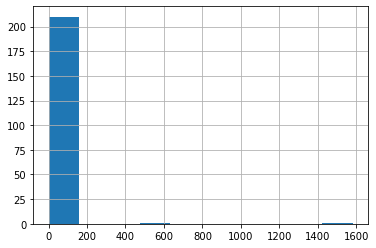

In [22]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count